In [3]:
import pymysql
import pandas as pd
import numpy as np
from pathlib import Path
import requests
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher
import threading
import time
from leuvenmapmatching import visualization as mmviz
import osmread
from sklearn.cluster import DBSCAN
from  decimal import Decimal
import osmnx as ox


In [2]:
#from leuvenmapmatching.matching_distance import MatcherDistance

In [3]:
# 数据库连接
def getTrajectory():
    # 打开数据库连接
    db = pymysql.connect("localhost", "root", "123456", "test", charset='utf8' )
    # 使用cursor()方法获取操作游标 
    cursor = db.cursor()
    sql = "SELECT * FROM taxi where id = 1131" 
    try:
       # 执行SQL语句
        cursor.execute(sql)
       # 获取所有记录列表
        results = np.array(cursor.fetchall())
    except:
       print ("Error: unable to fetch data")
    # 关闭数据库连接
    db.close()
    return results

In [4]:
# 用DBSCAN打上标签过滤
def markLabel(TRFromMysql,sleepTime = 10800):
    db = DBSCAN(eps=0.0008, min_samples=5)
    # 数据转换
    def convertDate(Date_time):
        DateLiet = Date_time.values
        timestamp = []
        for item in DateLiet:
            Date_time = int(time.mktime(item.timetuple()))
            timestamp.append(Date_time)
        return timestamp
    TR = pd.DataFrame(TRFromMysql)
    TR[[3]] = TR[[3]].apply(convertDate)
    # 打上标签
    db.fit(np.array(TR)[:,1:3])
    TR['label'] = db.labels_
    # 去除停留点
    stopCluser = []
    groups = TR.groupby('label')
    for clusterID, cluster in groups:
        if clusterID != -1 and len(cluster)> 5 and (cluster[3].max()-cluster[3].min()) > sleepTime:
            stopCluser.append(clusterID)
    TR = TR[~TR['label'].isin(stopCluser)]
    print (len(TR))
    # 去除新数据噪声
    db.fit(np.array(TR)[:,1:3])
    TR['label'] = db.labels_
    TR = TR[~TR['label'].isin([-1])]
    print(len(TR))
    return TR

In [5]:
TR = markLabel(getTrajectory())

4140
15


D:\anaconda\envs\Juah\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# 得到路径与坐标box
def getPath_Box(TR):
    path = np.array(TR.apply(lambda x:(float(x[1]),float(x[2])),axis=1))

    box = np.array(pd.DataFrame(TR)[[1,2]].apply(['min','max']))
    boxList = list(box[0])+list(box[1])
    return path, boxList

In [8]:
path,locationBox = getPath_Box(TR)

In [8]:
# 下载地图
def downloadMap(locationBox):
    headers = {'User-Agent':'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'}
    box = ','.join([str(i) for i in locationBox])
#     url = 'http://overpass-api.de/api/map?bbox=' + box
    url = 'https://www.openstreetmap.org/api/0.6/map?bbox='+box
    print ('地图数据：',url)
    xml_file = Path(".") / "osm.xml"
    r = requests.get(url, stream=True,headers=headers)
    with xml_file.open('wb') as ofile:
        for chunk in r.iter_content(chunk_size=10):
            if chunk:
                ofile.write(chunk)

In [9]:
downloadMap(locationBox)

地图数据： https://www.openstreetmap.org/api/0.6/map?bbox=116.48009,39.8163,116.54316,40.0118


In [10]:
locationBox

[Decimal('116.48009'),
 Decimal('39.8163'),
 Decimal('116.54316'),
 Decimal('40.0118')]

In [11]:
# 使用xml创建图
def createGraph(xml_file):
    map_con = InMemMap("myosm", use_latlon=True, use_rtree=True, index_edges=True)
    for entity in osmread.parse_file(str(xml_file)):
        if isinstance(entity, osmread.Way) and 'highway' in entity.tags:
            for node_a, node_b in zip(entity.nodes, entity.nodes[1:]):
                map_con.add_edge(node_a, node_b)
                # Some roads are one-way. We'll add both directions.
                map_con.add_edge(node_b, node_a)
        if isinstance(entity, osmread.Node):
            map_con.add_node(entity.id, (entity.lat, entity.lon))
    map_con.purge()
    return map_con

In [12]:
%time
map_graph = createGraph( Path(".") / "osm.xml")

Wall time: 0 ns


In [9]:
# 使用osmnx

# graph = ox.graph_from_place('beijing, china', network_type='drive')
graph = ox.graph_from_point((39.9,116.51),distance=3000,network_type='drive_service')
graph_proj = ox.project_graph(graph)
# Create GeoDataFrames
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

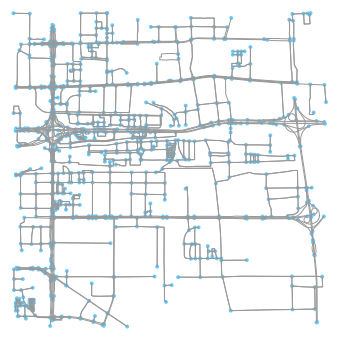

(<Figure size 561.23x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28cb8a99e80>)

In [38]:
ox.plot_graph(graph)

In [10]:
map_con = InMemMap("myosm", use_rtree=True, index_edges=True)

In [11]:

for nid, row in nodes_proj[['x', 'y']].iterrows():
    map_con.add_node(int(nid), (row['x'], row['y']))
for nid, row in edges_proj[['u', 'v']].iterrows():
    map_con.add_edge(row['u'], row['v'])
map_con.purge()

In [19]:
# from leuvenmapmatching.util.gpx import gpx_to_path

# #track = gpx_to_path("mytrack.gpx")
matcher = DistanceMatcher(map_con,
                         max_dist=0.8, 
                          #max_dist_init=25,  # meter
                         min_prob_norm=0.01,
                         #non_emitting_length_factor=0.75,
                         obs_noise=0.5, obs_noise_ne=0.7,  # meter
                         dist_noise=5,  # meter
                         non_emitting_states=True)
# matcher = DistanceMatcher(map_con, max_dist=1, min_prob_norm=0.05)
# states, lastidx = matcher.match(list(path))

In [15]:
path1 =[(i[1],i[0]) for i in path]

In [21]:
states, _ = matcher.match(path1)

nodes = matcher.path_pred_onlynodes

print("States\n------")
print(states)
print("Nodes\n------")
print(nodes)
print("")
matcher.print_lattice_stats()

States
------
[]
Nodes
------
[]

Stats lattice
-------------
nbr levels               : 15
nbr lattice              : 0
avg lattice[level]       : 0.0
min lattice[level]       : 0
max lattice[level]       : 0


Lowered zoom level to keep map size reasonable. (z = 12)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x1f30fcba470>)

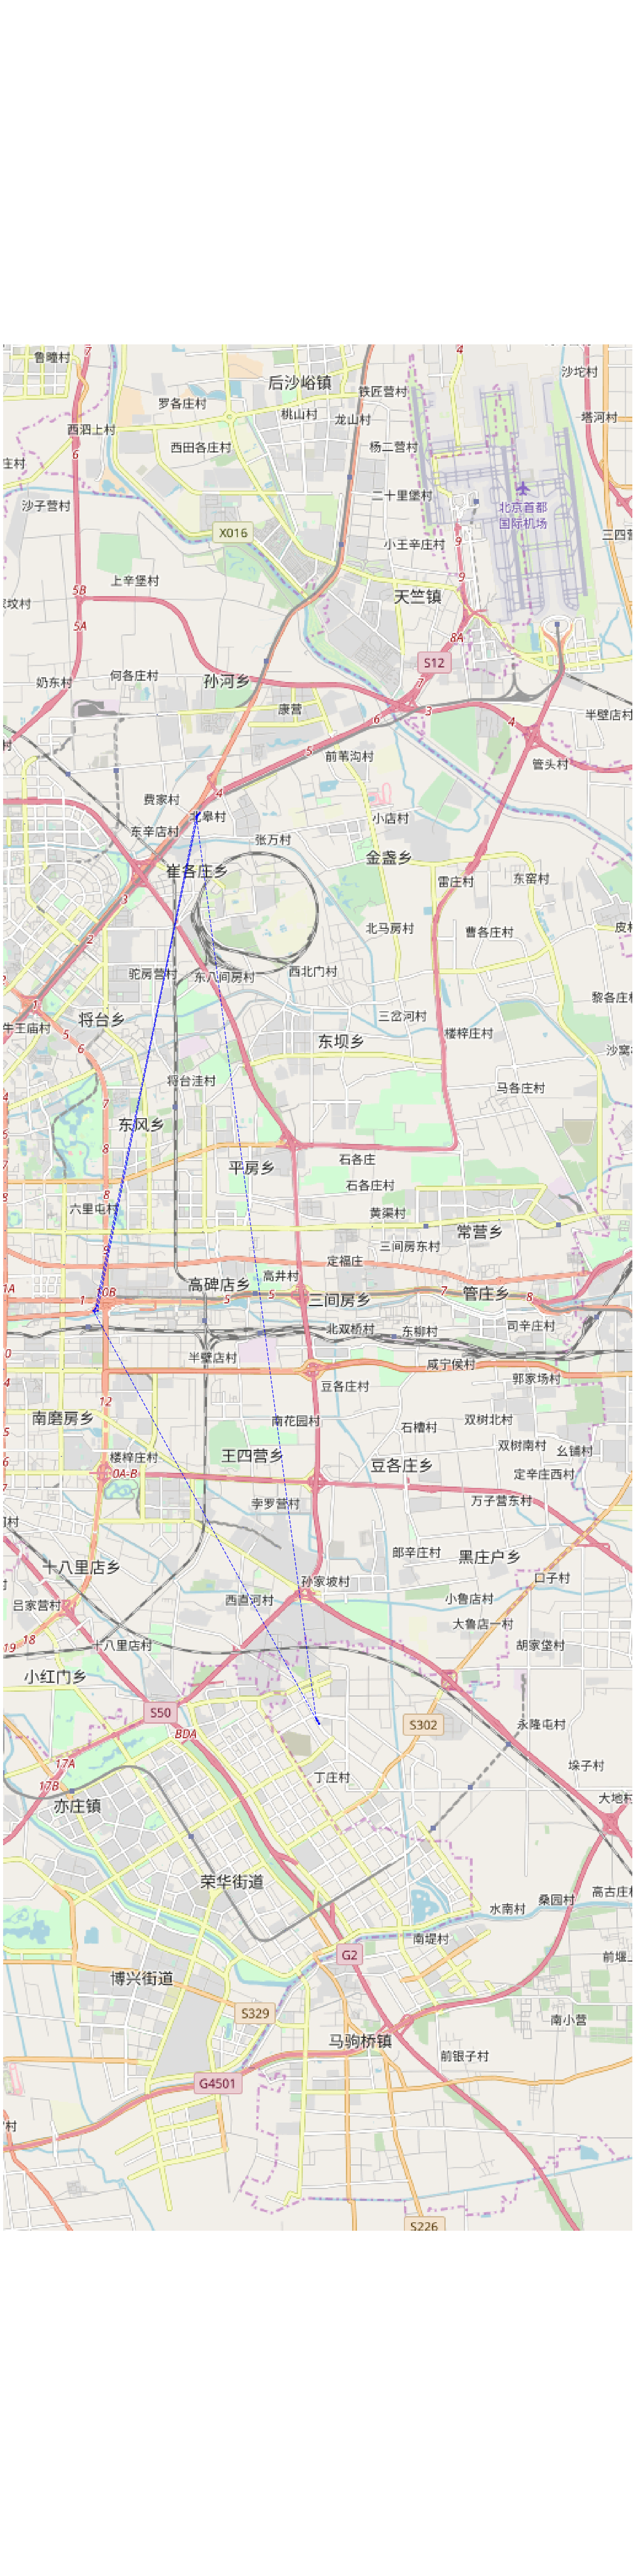

In [22]:
# pdb.set_trace()
mmviz.plot_map(map_con, matcher=matcher,
                use_osm=True, zoom_path=True,
                show_labels=False, show_matching=True, show_graph=False,
                filename="my_osm_plot.png")
# pdb.set_trace()

In [19]:
# mmviz.plot_map(map_graph,use_osm=True,path=path)

In [56]:
# import json
# import xml.dom.minidom

# dom = xml.dom.minidom.parse('osm.xml')
# root = dom.documentElement
# nodelist = root.getElementsByTagName('node')
# waylist = root.getElementsByTagName('way')

# node_dic = {}

# #统计记录所有node
# for node in nodelist:
#     node_id = node.getAttribute('id')
#     node_lat = float(node.getAttribute('lat'))
#     node_lon = float(node.getAttribute('lon'))
#     node_dic[node_id] = (node_lat, node_lon)

# print (len(node_dic))

# #排除非路node
# for way in waylist:
#     taglist = way.getElementsByTagName('tag')
#     road_flag = False
#     for tag in taglist:
#         if tag.getAttribute('k') == 'highway':
#             road_flag = True
#     if not road_flag:
#         ndlist = way.getElementsByTagName('nd')
#         for nd in ndlist:
#             nd_id = nd.getAttribute('ref')
#             if nd_id in node_dic:
#                 node_dic.pop(nd_id)

# #print len(node_dic)


# with open('pure_map_big.json', 'w') as fout:
#     json.dump(node_dic, fout)

In [57]:
# for  i in waylist:
#     print (i.getElementsByTagName())

In [53]:
#pd.DataFrame(node_dic)

In [55]:
# mmviz.plot_map(map_graph, matcher=matcher,
#                 use_osm=True, zoom_path=True,
#                 show_labels=False, show_matching=True, show_graph=False,
#                 filename="my_osm_plot.png")

In [6]:


map_con = InMemMap("mymap", graph={
    "A": ((1, 1), ["B", "C", "X"]),
    "B": ((1, 3), ["A", "C", "D", "K"]),
    "C": ((2, 2), ["A", "B", "D", "E", "X", "Y"]),
    "D": ((2, 4), ["B", "C", "D", "E", "K", "L"]),
    "E": ((3, 3), ["C", "D", "F", "Y"]),
    "F": ((3, 5), ["D", "E", "L"]),
    "X": ((2, 0), ["A", "C", "Y"]),
    "Y": ((3, 1), ["X", "C", "E"]),
    "K": ((1, 5), ["B", "D", "L"]),
    "L": ((2, 6), ["K", "D", "F"])
}, use_latlon=False)

path = [(0.8, 0.7), (0.9, 0.7), (1.1, 1.0), (1.2, 1.5), (1.2, 1.6), (1.1, 2.0),
        (1.1, 2.3), (1.3, 2.9), (1.2, 3.1), (1.5, 3.2), (1.8, 3.5), (2.0, 3.7),
        (2.3, 3.5), (2.4, 3.2), (2.6, 3.1), (2.9, 3.1), (3.0, 3.2),
        (3.1, 3.8), (3.0, 4.0), (3.1, 4.3), (3.1, 4.6), (3.0, 4.9)]

matcher = DistanceMatcher(map_con, max_dist=2, obs_noise=1, min_prob_norm=0.5)
states, _ = matcher.match(path)

nodes = matcher.path_pred_onlynodes

print("States\n------")
print(states)
print("Nodes\n------")
print(nodes)
print("")
matcher.print_lattice_stats()

Searching closeby nodes with linear search, use an index and set max_dist


States
------
[('X', 'A'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('B', 'D'), ('B', 'D'), ('B', 'D'), ('B', 'D'), ('D', 'E'), ('D', 'E'), ('D', 'E'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F')]
Nodes
------
['X', 'A', 'B', 'D', 'E', 'F']

Stats lattice
-------------
nbr levels               : 22
nbr lattice              : 929
avg lattice[level]       : 42.22727272727273
min lattice[level]       : 7
max lattice[level]       : 85
avg obs distance         : 0.15514927458475236
last logprob             : -0.5464565099511667
last length              : 22
last norm logprob        : -0.024838932270507576


In [69]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import math as m
from haversine import haversine

org = (27.5075, 77.6779)
dst = (27.5067, 77.6694)
dist = 1000
north, south, east, west = ox.bbox_from_point(org, distance=dist)

In [72]:
ox.bbox_from_point(org, distance=dist)

(27.516518034197805, 27.498481952506403, 77.68801379653065, 77.66778610180525)

In [109]:
G1 = ox.graph_from_bbox(north=40.0118, south=39.8163, east=116.54316, west=116.48009,
                       retain_all=True, truncate_by_edge=True, simplify=False,
                       network_type='none')
#fig, ax = ox.plot_graph(ox.project_graph(G))

In [136]:
G1